## Configure

In [1]:
import torch
from pathlib import Path
from notebook_setup import device
from torchvision import transforms
%load_ext autoreload
%autoreload 2
    
device = torch.device("cuda:1") # Set device here

/home/brendan/anaconda3/envs/dgm-geo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading the Model

Define a wrapper for the diffusers UNet class

In [2]:
import torch.nn as nn
from diffusers import StableDiffusionPipeline
from models.diffusions.sdes import VpSde


class UNet2DConditionalWrapper(nn.Module):
    def __init__(self, unet):
        super().__init__()
        self.unet = unet

    def forward(self, x, t, **kwargs):
        t = t * 1000
        return -self.unet(sample=x, timestep=t, **kwargs).sample
        

pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", safety_checker=None).to(device)
unet = UNet2DConditionalWrapper(pipe.unet)
sde = VpSde(unet)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Loading pipeline components...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:07<00:00,  1.28s/it]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enab

In [3]:
data_transform = transforms.Compose([
    transforms.Resize(512),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])
reverse_transform = lambda x: pipe.image_processor.postprocess(x)[0]

# Locating Memorized Samples and Captions

In [4]:
import pandas as pd

df = pd.read_parquet('/data/diffusion-mem/datasets/sdv1_bb_edge_groundtruth.parquet')
df.head()

,caption,index,scores,url,numdups,edge_scores,mse_real_gen,overfit_type,gen_seeds,retrieved_urls
26136,"email, envelope, mail icon",1730933243,3641343.50,https://cdn3.iconfinder.com/data/icons/snowish...,12,-0.925842,18873.220703,N,[],[]
25877,"communication, email, mail, message, online, o...",2137580772,3646829.00,https://cdn2.iconfinder.com/data/icons/e-mail-...,8,-0.916794,35563.359375,N,[],[]
22716,The No Limits Business Woman Podcast,1030727993,3970528.00,https://onlinecoach1.hipcast.com/albumart/1000...,811,-0.916794,299.445984,MV,[],[]
27018,"lock, locked, padlock, protected, protection, ...",1155508791,3643078.50,https://cdn3.iconfinder.com/data/icons/police-...,6,-0.914291,23157.097656,N,[],[]
406,"""3M™ Privacy Filter for 24"""" Widescreen Monito...",1953226014,3632179.75,https://cdn.shopify.com/s/files/1/0250/9953/44...,6,-0.868073,45242.625000,N,[],[]


### Generating a sample with a memorized caption

First, try generating the sample with our own code.

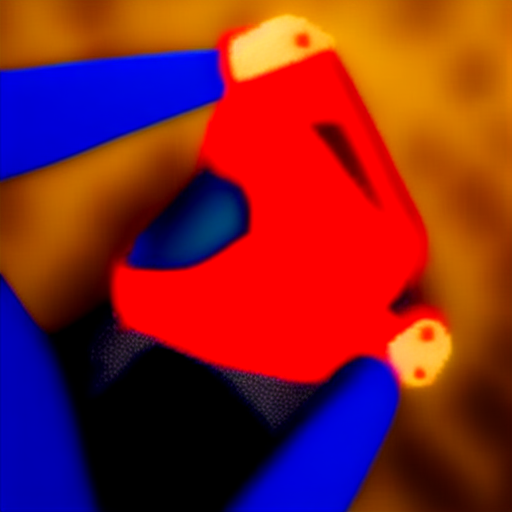

In [5]:
sample_img_data = df[df['overfit_type'] != 'N'].iloc[1]
sample_prompt = sample_img_data['caption']


def encode_prompt(prompt):
    prompt_embeds, neg_prompt_embeds = pipe.encode_prompt(
        prompt, 
        device, 
        num_images_per_prompt=1,
        do_classifier_free_guidance=False,
    )
    return prompt_embeds


prompt_embeds = encode_prompt(sample_prompt)
z_noise = pipe.prepare_latents(
    batch_size=1,
    num_channels_latents=pipe.unet.config.in_channels,
    height=pipe.unet.config.sample_size * pipe.vae_scale_factor,
    width=pipe.unet.config.sample_size * pipe.vae_scale_factor,
    dtype=prompt_embeds.dtype,
    device=device,
    generator=None,
    latents=None,
)

with torch.no_grad():
    z_0 = sde.solve_reverse_sde(z_noise, steps=999, encoder_hidden_states=prompt_embeds)
    x_0 = pipe.vae.decode(z_0 / pipe.vae.config.scaling_factor, return_dict=False)[0]
    image = reverse_transform(x_0)

image

Now generate with the huggingface code (uses PNDM, a better solver).

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [01:39<00:00, 10.01it/s]


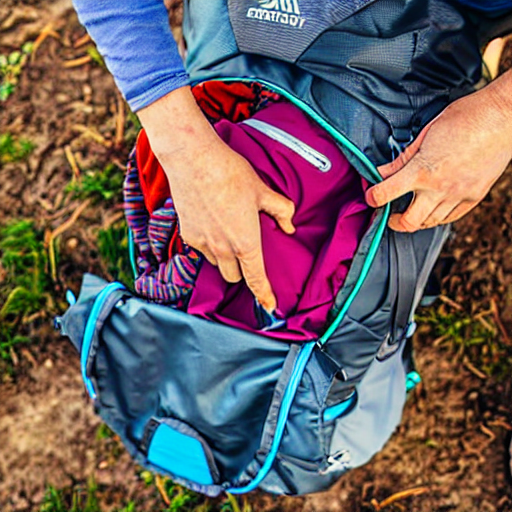

In [6]:
image = pipe(
    sample_prompt, 
    num_inference_steps=999, 
    use_karras_sigmas=True, 
    generator=torch.Generator("cuda").manual_seed(0)
).images[0]
image

### Downloading Groundtruth

There are 3 types of memorized captions here:
1) Matching verbatim (`overfit_type == 'MV'`), where the generated images matches the image corresponding to the caption (which is located at `url`
2) Retrieval verbatim (`overfit_type == 'RV'`), where the generated image matches an image corresponding to *different* captions (located at `retrieved_urls`)
3) Template verbatim (`overfit_type == 'TV'`), where *some aspects* of the generated image match an image corresponding to *different* captions ( again located at `retrieved_urls`)

The dataframe also includes some images with no match (`overfit_type == 'N'`).

First, let us download all the original images and retrieved images and encode them into the stable diffusion latent space.

In [7]:
import requests
from torchvision import transforms
from PIL import Image


def download_pil(url, timeout=0.1):
    try:
        return Image.open(requests.get(url, stream=True, timeout=0.1).raw)
    except:
        return None

def encode_im(im):
    if im is None:
        return None
    else:
        im_tensor = data_transform(im)[None, :3, ...]
        if im_tensor.shape[1] == 1:
            im_tensor = im_tensor.tile(1, 3, 1, 1)
            
        with torch.no_grad():
            im_encoding = pipe.vae.encode(im_tensor.to(device)).latent_dist.mean
        
        return im_encoding.cpu() * pipe.vae.config.scaling_factor

def decode_latent(z):
    return pipe.vae.decode(z / pipe.vae.config.scaling_factor, return_dict=False)[0]
    

df['pil'] = df['url'].apply(download_pil)
df['retrieved_pils'] = df['retrieved_urls'].apply(
    lambda urls: [download_pil(url) for url in urls])
img_encodings = df['pil'].apply(encode_im)
retrieved_encodings = df['retrieved_pils'].apply(lambda pils: [encode_im(pil) for pil in pils])

Now, create a sample ground truth of image encodings of each type (matching verbatim, retrieval verbatim, template verbatim, and no match). We postulate that this ordering can be detected: MV = RV < TV < N.

In [8]:
num_per_category = 4

mem_latents = {}
mem_prompts = {}

for overfit_type in ('MV', 'N'):
    index = df[(df['overfit_type'] == overfit_type) & ~df['pil'].isna()].index[:num_per_category]
    mem_latents[overfit_type] = torch.cat(tuple(img_encodings[index]))
    mem_prompts[overfit_type] = df.loc[index]['caption']

for overfit_type in ('RV', 'TV'):
    index = df[(df['overfit_type'] == overfit_type) & ~df['retrieved_pils'].str[0].isna()].index[:num_per_category]
    first_retrieved = [retrieved_ims[0] for retrieved_ims in retrieved_encodings[index]]
    mem_latents[overfit_type] = torch.cat(tuple(first_retrieved))
    mem_prompts[overfit_type] = df.loc[index]['caption']

### Reconstruction

Put all datapoints and prompts together in one tensor

In [9]:
overfit_types = ('MV', 'RV', 'TV', 'N')

latents = torch.cat(tuple(mem_latents[ot] for ot in overfit_types))
prompts = pd.concat(mem_prompts[ot] for ot in overfit_types).tolist()
with torch.no_grad():
    prompt_embeds = encode_prompt(prompts)

Reconstruct all the latents at different noise levels

In [ ]:
import math
import torch
from tqdm import tqdm


batch_size = 2
noise_levels = torch.tensor([1e-3, 1e-2, 1e-1, 2e-1, 4e-1, 6e-1, 8e-1])

latents_noised = {}
latents_recon = {}

for noise_level in noise_levels:
    latents_noised[noise_level] = sde.solve_forward_sde(
        latents.to(device), 
        t_end=noise_level.to(device),
    ).cpu()
    
    latents_recon[noise_level] = []
    pbar = tqdm(zip(latents_noised[noise_level].split(batch_size), prompt_embeds.split(batch_size)))
    pbar.set_description(f'Reconstructing latents for noise level {noise_level}')
    
    for latent, prompt in pbar:
        steps = math.ceil(noise_level * 1000)
        recons = sde.solve_reverse_ode(
            latent.to(device), 
            encoder_hidden_states=prompt.to(device), 
            t_start=noise_level.to(device), 
            steps=steps
        ).cpu()
        latents_recon[noise_level].append(recons)

    latents_recon[noise_level] = torch.cat(latents_recon[noise_level])

In [ ]:
ims_display_order = []

for im_index, _ in enumerate(latents):
    ims_noised = []
    ims_recon = []
    
    for noise_level in latents_noised.keys():
        latent_noised = latents_noised[noise_level][im_index:im_index+1]
        latent_recon = latents_recon[noise_level][im_index:im_index+1]
        
        with torch.no_grad():
            ims_noised.append(decode_latent(latent_noised.to(device)).cpu())
            ims_recon.append(decode_latent(latent_recon.to(device)).cpu())

    ims_display_order.extend(ims_noised)
    ims_display_order.extend(ims_recon)

ims_display_order = torch.cat(ims_display_order)

In [ ]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


image_grid([reverse_transform(im) for im in ims_display_order.split(1)], 
           rows=2*len(latents), cols=len(noise_levels))